Figure out actual priority dates of patents

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [8]:
master = pd.read_csv('data/master_503107.csv')

related = pd.read_csv('data/usreldoc.tsv', delimiter='\t'\
            , usecols=['patent_id','doctype','relkind','reldocno','date','status','sequence'])

First, figure out the earliest date for each patent for continuations

In [9]:
related.head()

,patent_id,doctype,relkind,reldocno,date,status,sequence
0,8501207,continuation-in-part,child-doc,09969456,0000-00-00,NaN,10
1,7519253,us-provisional-application,NaN,60738389,2005-11-18,NaN,0
2,8045312,continuation,child-doc,12477790,0000-00-00,NaN,2
3,8622319,continuation,parent-doc,11009621,2004-12-10,ABANDONED,0
4,8706267,division,parent-grant-document,7444191,0000-00-00,NaN,1


In [11]:
related.relkind.unique()

array(['child-doc', nan, 'parent-doc', 'parent-grant-document',
       'parent_grant_document', 'parent-pct-document', 'parent_doc',
       'child_doc', 'parent_pct_document'], dtype=object)

In [23]:
related.dropna(axis=0, subset=['relkind'],inplace=True)

#only care about granted patents and patents in our master list
related = related.loc[(related.relkind.str.contains('grant'))\
                      & (related.patent_id.isin(master.patent_number.tolist()))]

/home/tiera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
related.head()

,patent_id,doctype,relkind,reldocno,date,status,sequence
96,D703271,continuation,parent-grant-document,D682944,0000-00-00,NaN,1
905,D505325,division,parent-grant-document,D490313,2004-05-25,NaN,1
1154,D610544,continuation,parent-grant-document,7110656,0000-00-00,NaN,12
1496,D498090,division,parent_grant_document,D480232,0000-00-00,NaN,2
1633,D669452,continuation,parent-grant-document,D642161,0000-00-00,NaN,4


In [67]:
#seeds will be listed under reldocno (as a patent), but not as a patent_id (due to not having a parent)
seed = related.loc[~related.patent_id.isin(related.reldocno.tolist())]
seed.head()

,patent_id,doctype,relkind,reldocno,date,status,sequence
905,D505325,division,parent-grant-document,D490313,2004-05-25,NaN,1
1154,D610544,continuation,parent-grant-document,7110656,0000-00-00,NaN,12
1496,D498090,division,parent_grant_document,D480232,0000-00-00,NaN,2
1968,D681957,division,parent-grant-document,D673777,0000-00-00,NaN,1
2074,D651113,division,parent-grant-document,D647812,0000-00-00,NaN,1


In [79]:
print('number of patent family seeds: ',seed.reldocno.nunique(),'\nnumber of patents represented: ', seed.patent_id.nunique())

number of patent family seeds:  17218 
number of patents represented:  18289


hmmm...these number arnt the same..investigate

In [75]:
seed.loc[seed.duplicated('reldocno', keep=False)].sort_values('reldocno')

,patent_id,doctype,relkind,reldocno,date,status,sequence
826352,D530439,continuation,parent-grant-document,4577263,1996-03-18,NaN,14
5496577,D530438,continuation,parent-grant-document,4577263,0000-00-00,NaN,12
8056985,D530439,continuation,parent-grant-document,4658336,1987-04-14,NaN,11
388819,D530438,continuation,parent-grant-document,4658336,0000-00-00,NaN,9
3660749,D530439,continuation,parent-grant-document,4899265,1990-07-06,NaN,6
868356,D530438,continuation,parent-grant-document,4899265,0000-00-00,NaN,4
5835539,D530439,division,parent-grant-document,4942505,1990-07-17,NaN,3
2603265,D530438,division,parent-grant-document,4942505,0000-00-00,NaN,1
3273189,D453402,continuation,parent_grant_document,5314509,0000-00-00,NaN,36
3907387,D453402,continuation,parent_grant_document,5314509,0000-00-00,NaN,37


Some patents use the same seed. Also patents are listed with multiple seeds, which isn't quite correct

In [97]:
#select the earliest (highest sequence) seed for each patent

indices = seed.groupby('patent_id')['sequence'].idxmax
seed = seed.loc[indices]

In [100]:
print('number of patent family seeds: ',seed.reldocno.nunique(),'\nnumber of patents represented: ', seed.patent_id.nunique())

number of patent family seeds:  13559 
number of patents represented:  18289


Mark each family group

In [136]:
family_size = related.loc[related.reldocno.isin(seed.reldocno.tolist())].groupby('reldocno')['patent_id'].count()\
.apply(lambda x: x+1).reset_index().rename(index=str, columns={'reldocno':'seed_patent', 'patent_id':'family_size'})

Text(0,0.5,'Number of seed patents')

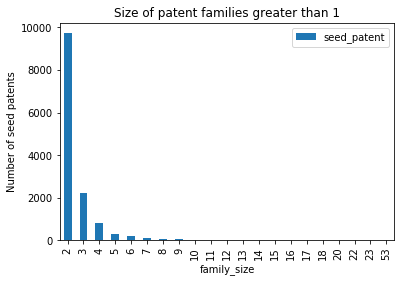

In [141]:
ax = family_size.groupby('family_size').count().plot(kind='bar', title='Size of patent families greater than 1')
ax.set_ylabel('Number of seed patents')

Patents not part of family

In [176]:
temp = pd.DataFrame(master\
                    .loc[~master.patent_number.isin(list(set(related.patent_id.tolist()\
                                                             + related.reldocno.tolist())))]['patent_number'])
temp['family_size'] = 1
temp = temp.rename(index=str, columns={'patent_number':'seed_patent'})

In [181]:
family_size = family_size.append(temp, ignore_index=True)

Text(0,0.5,'Number of seed patents')

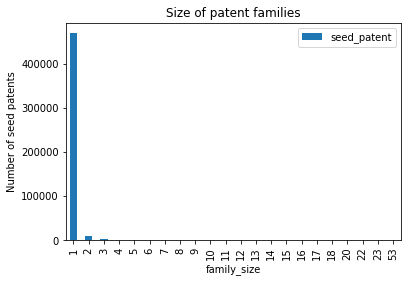

In [182]:
ax = family_size.groupby('family_size').count().plot(kind='bar', title='Size of patent families')
ax.set_ylabel('Number of seed patents')

Select application data we already have

In [226]:
seed_list = seed.reldocno.tolist()
seed_app_years_already_have = master.loc[master.patent_number.isin(seed_list)][['patent_number','app_year']]

Calculate application years of seed patents - will gather this data from the data using data pulling file

In [240]:
seeds_needs = list(seed.loc[~seed.reldocno.isin(master.patent_number.tolist())].reldocno.unique())
file_Name = "seeds_need"
# open the file for writing
fileObject = open(file_Name,'wb') 

# this writes the object a to the
# file named 'testfile'
pickle.dump(seeds_needs,fileObject)   

# here we close the fileObject
fileObject.close()

# Recalibrate priority year based off calculations above

first make set priority year on application year...just to keep everything on the same level

In [196]:
master['priority_year'] = master.app_year

In [ ]:
a = ['test value','test value 2','test value 3']
a
['test value','test value 2','test value 3']

# file_Name = "testfile"
# # open the file for writing
# fileObject = open(file_Name,'wb') 

# # this writes the object a to the
# # file named 'testfile'
# pickle.dump(a,fileObject)   

# # here we close the fileObject
# fileObject.close()
# we open the file for reading
fileObject = open(file_Name,'r')  
# load the object from the file into var b
b = pickle.load(fileObject)  
b
['test value','test value 2','test value 3']
a==b
True